# "Sure" Insurance Analytics: Customer Insights, Predictive Modelling, and Data Privacy through Obfuscation with Machine Learning for Sure Tomorrow

This project will explore the application of machine learning in solving real-world challenges for Sure Tomorrow, an insurance company seeking to enhance its customer service and marketing efforts. The company has tasked me with addressing four distinct problems using machine learning models, with a focus on both predictive accuracy and data privacy.

Customer Similarity: The first task is to develop a model to identify customers with profiles similar to a given individual. This will help Sure Tomorrow's agents target marketing efforts more effectively.
Insurance Benefit Prediction: The second task involves building a model to predict the likelihood of a new customer receiving an insurance benefit, while comparing its performance against a simple dummy model.
Benefit Quantity Prediction: In the third task, I will apply linear regression to predict the number of benefits a new customer is likely to receive, enabling the company to better allocate resources and improve decision-making.
Data Privacy through Obfuscation: Lastly, the project will determine a way to protect sensitive customer data using data obfuscation techniques and ensuring that personal information could not be reconstructed if the data were compromised, all while preserving the model's predictive abilities.

# Data Preprocessing & Exploration

## Initialization

In [3]:
# Standard library imports
import math

# Third-party imports
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

# Scikit-learn imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler


## Loading Data

In [4]:
df = pd.read_csv('/datasets/insurance_us.csv')

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
142,0,22.0,38000.0,2,0
2994,1,29.0,32200.0,1,0
482,1,37.0,41200.0,4,0
3814,0,33.0,17800.0,3,0
1905,1,26.0,38000.0,2,0
1392,1,22.0,39100.0,1,0
2752,1,27.0,21100.0,1,0
795,1,26.0,51200.0,1,0
4824,1,20.0,46500.0,0,0
2424,1,18.0,57100.0,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
# fixing the age type (from float to int)
df['age'] = df['age'].astype(int)

In [9]:
# checking to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [10]:
# descriptive statistics. 
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


The data set contains data for 5000 customers of Sure Tomorrow.  In terms of gender, the customer sample is split approximately 50/50.  Given the data was sent without clarification as to which gender corresponds to 0 vs 1, we will assume the general convention was followed of 0 for female, 1 for male.  The customers represent all adult age groups 18-65, though the data includes primarily younger customers under 40.  Customer income is typical, assuming the salary is in USD and represents US customers.  The median of 40k corresponds to the US median of 37k, though the data ranges from presumably part-time employment earning only 5k per year up to 79k for the highest earner in the set.  Families included in the data are primarily small, with approximately 3/4 of customers having 0-2 family members, though the data contains families of up to 6.  Finally, with regard to insurance benefits paid out, 3/4 of the customers in the set have never made a claim, though at least one customer has made a claim every year for the past 5 years.

The data overall appears normal, but I will perform deeper exploratory data analysis before proceeding.

## EDA

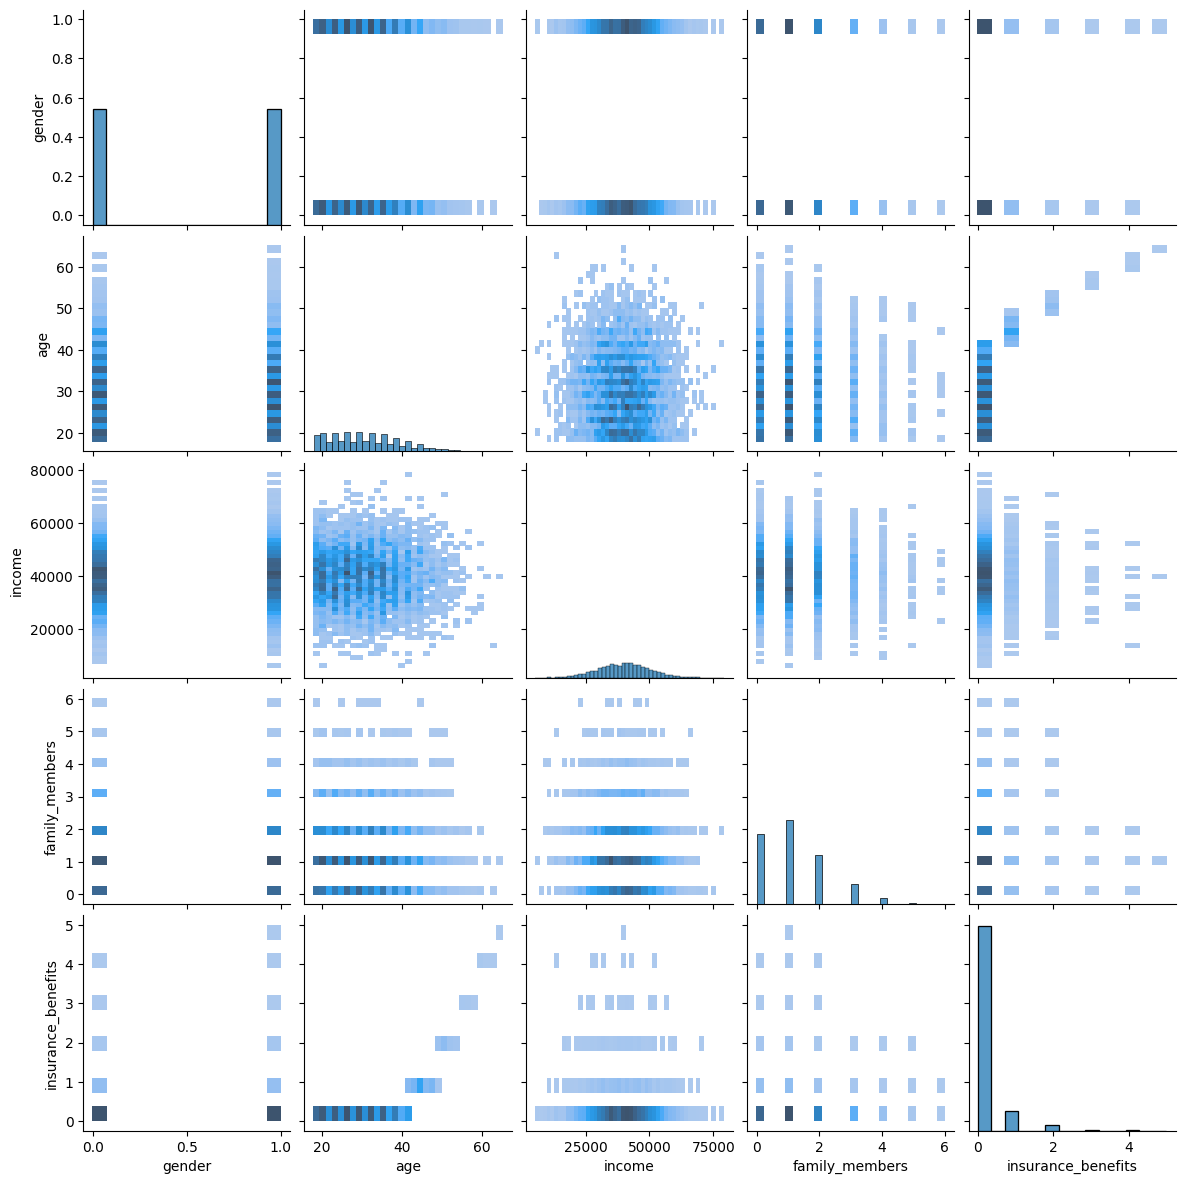

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

While it is difficult to spot obvious clusters as it is difficult to combine several variables simultaneously (to analyze multivariate distributions), a few observations can be made.  The 5-time claimant is an older male with an average income.  None of the claims have come from customers under 40 and the number of benefits claimed naturally increases with age.  Male customers have slightly higher incomes than female customers; in fact, the difference is seemingly precisely aligned with the wage gap in the US.  Family size is equally distributed across gender and has an inverse relationship with age.

LA and ML will help better evaluate distributions in depts.

# Task 1. Similar Customers

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']
target = 'insurance_benefits'

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
        
    nbrs = NearestNeighbors(metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], n_neighbors = k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [14]:
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names])

df_scaled = df.copy()
df_scaled[feature_names] = transformer_mas.transform(df[feature_names])
df_scaled_features = df_scaled.drop(columns=target)

In [15]:
df_scaled_features.describe()

,gender,age,income,family_members
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,0.476197,0.505270,0.199033
std,0.500049,0.129859,0.125318,0.181898
min,0.000000,0.276923,0.067089,0.000000
25%,0.000000,0.369231,0.421519,0.000000
50%,0.000000,0.461538,0.508861,0.166667
75%,1.000000,0.569231,0.589873,0.333333
max,1.000000,1.000000,1.000000,1.000000


Now, I will get similar records for every individual combination

In [16]:
metrics = ['euclidean', 'manhattan']
k = 5
n = np.random.randint(0, len(df))

In [17]:
print('Similar records to original, unscaled data:')
for metric in metrics:
    sim_recs = get_knn(df[feature_names], n, k, metric)
    print('Using metric:', metric)
    print(sim_recs)

Similar records to original, unscaled data:
Using metric: euclidean
      gender  age   income  family_members  distance
201        0   22  32100.0               0  0.000000
2359       1   23  32100.0               1  1.732051
4767       0   24  32100.0               1  2.236068
2072       0   19  32100.0               0  3.000000
3385       0   19  32100.0               1  3.162278
Using metric: manhattan
      gender  age   income  family_members  distance
201        0   22  32100.0               0       0.0
2072       0   19  32100.0               0       3.0
2359       1   23  32100.0               1       3.0
4767       0   24  32100.0               1       3.0
3385       0   19  32100.0               1       4.0


In [18]:
print('Similar records to scaled data:')
for metric in metrics:
    sim_scaled_recs = get_knn(df_scaled_features, n, k, metric)
    print('Using metric:', metric)
    print(sim_scaled_recs)

Similar records to scaled data:
Using metric: euclidean
      gender       age    income  family_members  distance
201      0.0  0.338462  0.406329             0.0  0.000000
2057     0.0  0.338462  0.402532             0.0  0.003797
1834     0.0  0.323077  0.401266             0.0  0.016196
4853     0.0  0.323077  0.397468             0.0  0.017754
2635     0.0  0.353846  0.416456             0.0  0.018418
Using metric: manhattan
      gender       age    income  family_members  distance
201      0.0  0.338462  0.406329             0.0  0.000000
2057     0.0  0.338462  0.402532             0.0  0.003797
1834     0.0  0.323077  0.401266             0.0  0.020448
4853     0.0  0.323077  0.397468             0.0  0.024245
2635     0.0  0.353846  0.416456             0.0  0.025511


The data not being scaled affects the kNN algorithm.  Having run the algorithm several times with a different random n, it is clear that income skews the algorithm more than the other features with the unscaled data, which explains why it does not overlap with the neighbors identified when the algorithm is run with the scaled data.  In every run, the income of all nearest neighbors is identical for the unscaled data, though other features may vary.  This is not the case with the scaled data, however.  When the algorithm is run on the scaled data, it seems to favor selecting records with the same gender and family_members.  Age tends to vary when run on the scaled data, but the variance is less than it is with the unscaled data.  Overall, the scaled data seems to be a more reliable option for machine learning purposes given that gender, age, and family_members are more likely to determine whether or not a customer receives an insurance benefit.  Income, while not inconsequential, does not impact the probability of receiving an insurance benefit as heavily as those features.

The results using the Manhattan distance metric are highly similar to the Euclidean metric, though there is some variance evident.  The algorithm weighs age more equally than the Euclidean metric, regardless of scaling, due to its reliance on absolute distance rather than squared distances like the Euclidean metric.  In many runs, the four nearest neighbors were the same, but the order was different due to the distance calculation.  In every case, scaled or unscaled, age was different between the records.  Some records had variance across other features, but age consistently impacted the distance calculation in every run.  Especially when the data is unscaled, the Manhattan distance is likely better as it is less sensitive to outliers and income disproportionally affects identification of similar customers.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning, this is a binary classification task as it predicts whether or not a benefit will be received, not how many benefits a given client will receive.

In [19]:
# calculating the target
df['ins_bens_recd'] = (df['insurance_benefits'] > 0).astype(int)
features = feature_names

df_target = df['ins_bens_recd']
df_features = df[features]

In [21]:
df_target.unique()

array([0, 1])

In [22]:
train_features, test_features, train_target, test_target = train_test_split(df_features, df_target, test_size=0.3, random_state=21, shuffle=True)

In [23]:
# Checking class distribution of the target variable
print("Train target distribution:")
print(train_target.value_counts())
print(train_target.value_counts(normalize=True))

print("\nTest target distribution:")
print(test_target.value_counts())
print(test_target.value_counts(normalize=True))

Train target distribution:
0    3119
1     381
Name: ins_bens_recd, dtype: int64
0    0.891143
1    0.108857
Name: ins_bens_recd, dtype: float64

Test target distribution:
0    1317
1     183
Name: ins_bens_recd, dtype: int64
0    0.878
1    0.122
Name: ins_bens_recd, dtype: float64


train_test_split provided a similar distribution for all possible targets.  The distribution of benefit received versus not is within 1% for both the training and test sets.

In [24]:
#scaled features option
train_features_scaled = train_features.copy()
train_features_scaled = transformer_mas.fit_transform(train_features)

test_features_scaled = test_features.copy()
test_features_scaled = transformer_mas.transform(test_features)

In [25]:
for k in range(1, 11):
    #orig
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_features, train_target)
    preds = classifier.predict(test_features)
    #scaled
    classifier.fit(train_features_scaled, train_target)
    scaled_preds = classifier.predict(test_features_scaled)

In [48]:
def eval_classifier(y_true, y_pred):
    
    f1 = sklearn.metrics.f1_score(y_true, y_pred, average='micro')
    print(f'F1: {f1:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Normalized Confusion Matrix')
    print(cm)

In [49]:
eval_classifier(test_target, preds)

F1: 0.88
Normalized Confusion Matrix
[[0.878 0.   ]
 [0.12  0.002]]


In [50]:
eval_classifier(test_target, scaled_preds)

F1: 0.98
Normalized Confusion Matrix
[[0.878      0.        ]
 [0.02466667 0.09733333]]


While the classifier produces good predictions with the unscaled data (F1: 0.88), it produces very good predictions on the scaled data (F1: 0.98).  Let's check those scores against a random model.

In [29]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [30]:
for P in [0, df['insurance_benefits'].mean(), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df), seed=42)
        
    eval_classifier(df['insurance_benefits'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.89
Normalized Confusion Matrix
[[8.872e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [8.460e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.300e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [3.600e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.400e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]]

The probability: 0.15
F1: 0.77
Normalized Confusion Matrix
[[7.592e-01 1.280e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [7.020e-02 1.440e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.040e-02 2.600e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [3.000e-03 6.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.200e-03 2.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]]

The probability: 0.50
F1: 0.50
Normalized Confusion Matrix
[[4.560e-01 4.312e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00]


The random model tested on probability 0 achieved the best F1 score at 0.89, which is not surprising given the vast majority of the 5000 customers in the data set have never made a claim.  This is only slightly better than the F1 achieved with the unscaled data (0.88), further confirming that unscaled data lends more reliable predictions.

# Task 3. Regression (with Linear Regression)

In [27]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [28]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [29]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [30]:
# scaling new data split
X_train_scaled = X_train.copy()
X_train_scaled = transformer_mas.fit_transform(X_train)

X_test_scaled = X_test.copy()
X_test_scaled = transformer_mas.transform(X_test)

In [31]:
lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


Though the specific output differs, the RMSE metric and R2 remain the same with Linear Regression whether the data is unscaled or scaled.  In both cases, the R2 indicates a strong but realistic positive correlation between real and predicted values.  The RMSE is reasonably good for a first attempt given we are making binary predictions, and it is significantly better than random guessing.

# Task 4. Obfuscating Data

In [32]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [33]:
X = df_pn.to_numpy()
len(X)

5000

Generating a random matrix $P$.

In [34]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible.

In [35]:
det_P = np.linalg.det(P)

if det_P != 0:
    print('The matrix is invertible.')
    
else:
    print('The matrix is not invertible.')

The matrix is invertible.


In [49]:
Xdot = X.dot(P)
X_res = np.linalg.solve(P.T, Xdot.T).T

if len(np.isin(X, X_res)) == len(X):
    print('It is possible to recover the original data.')
else:
    print('It is not possible to fully recover the original data.')

It is possible to recover the original data.


In [37]:
print('Original Data:')
print(pd.DataFrame(X[:3, :]))
print('Data Type:', X.dtype)
print('\nTransformed Data:')
print(pd.DataFrame(Xdot[:3, :]))
print('Data Type:', Xdot.dtype)
print('\nReversed Data:')
print(pd.DataFrame(X_res[:3, :]))
print('Data Type:', X_res.dtype)

Original Data:
     0     1        2    3
0  1.0  41.0  49600.0  1.0
1  0.0  46.0  38000.0  1.0
2  0.0  29.0  21000.0  0.0
Data Type: float64

Transformed Data:
             0             1             2             3
0  6359.715273  22380.404676  18424.090742  46000.696690
1  4873.294065  17160.367030  14125.780761  35253.455773
2  2693.117429   9486.397744   7808.831560  19484.860631
Data Type: float64

Reversed Data:
              0     1        2             3
0  1.000000e+00  41.0  49600.0  1.000000e+00
1 -2.482685e-13  46.0  38000.0  1.000000e+00
2 -1.241343e-14  29.0  21000.0  1.077078e-12
Data Type: float64


There are some extremely minor differences in the data due to rounding errors.  Float64 has inherent limits on its precision.  However, it runs calculations much quicker than other libraries.  The code below demonstrates that these differences are inconsequential for this real-world application.

In [38]:
if np.allclose(X, X_res, atol=1e-10):
    print('Original and restored data are within tolerance.')
    
else:
    print('Discrepancies detected.')

Original and restored data are within tolerance.


## Proof That Data Obfuscation Can Work with LR

$w_P$ is the linear transformation of $w$ by a matrix of random values ($P$).  Given the formula for $w_P$:
$$w_P = [(XP)^T XP]^{-1} (XP)^T y$$
Due to distributivity:
$$(XP)^T = P^TX^T$$
Which when substituted into the original formula gives:
$$w_P = [P^TX^T XP]^{-1} P^TX^T y$$
Then, due to reversibility of the transpose of a product of matrices, we can isolate $P$ so that 
$$w_P = P^{-1}[(X^T X)^{-1} X^T]y$$
Which can be simplified further as $$w_P = P^{-1}w$$ 
This inversion is needed to transform the data back to its initial form before P transformed the data.

**Analytical proof**

Because of the nature of linear transformation and specifically the reversivity of the transpose of a product of matrices, the predicted values will merely be the values of $w$ transformed by an invertible matrix P.  While $w_P \neq w$: $$wP = P^{-1}w$$  This reversibility ensures the final results are unaffected.

RMSE is based on the magnitude of errors, and this magnitude will have the same error distribution when a consistent linear transformation is applied.  Thus, RMSE will be the same for both $w$ or $w_P$ because transformations by P are reversible.  Obfuscation of the data, therefore, will not affect the accuracy of the model because it affects neither the distribution of errors nor the final predictions.

To further illustrate this:
$$\hat{y} = X'w_P$$
When we substitute in the formula for $w_P$, we have:
$$\hat{y} = X'[(XP)^T XP]^{-1} (XP)^T y$$
Distributivity of the transpose means this could also be written as:
$$\hat{y} = X'[X^T P^T XP]^{-1} X^T P^T y$$
P can now be isolated based on the associative property of multiplication, giving us:
$$\hat{y} = X'P(X^T X)^{-1} X^T y$$
$w = (X^T X)^{-1} X^T y$  Therefore, this can be further simplified as:
$$\hat{y} = X'Pw$$
Given $X' = XP$ and $ w_P = P^{-1}w$, so we can substitute them into the formula instead:
$$\hat{y} = XPP^{-1}w$$
$PP^{-1}$ in this context forms an identity matrix that can be cancelled out as multiplying by an identity matrix will not change the result of the equation.  With this in mind, we have:
$$\hat{y} = Xw = Xw_P$$
Therefore, predicted values will be identical regardless of the weight applied to obfuscate the data as obfuscation can be reversed and thus affects intermediate computation but not final results.

## Testing Linear Regression With Data Obfuscation

In [39]:
rng = np.random.default_rng(seed=21)
P2 = rng.random(size=(X.shape[1], X.shape[1]))

In [40]:
det_P2 = np.linalg.det(P2)

if det_P2 != 0:
    print('The matrix is invertible.')
    
else:
    print('The matrix is not invertible.')

The matrix is invertible.


In [41]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=12345)

lr2 = MyLinearRegression()

lr2.fit(X_train2, y_train2)

y_test_pred2 = lr2.predict(X_test2)
eval_regressor(y_test2, y_test_pred2)

RMSE: 0.34
R2: 0.66


In [42]:
Xdot2_train = X_train2.dot(P2)
Xdot2_test = X_test2.dot(P2)

lr_obf = MyLinearRegression()

lr_obf.fit(Xdot2_train, y_train)

y_test_pred_obf = lr_obf.predict(Xdot2_test)
eval_regressor(y_test2, y_test_pred_obf)

RMSE: 0.34
R2: 0.66


The obfuscation does not impact the quality of the predictions.  Both RMSE and R2 are the same when run on either dataset.

# Conclusions

This project explored applications of machine learning and linear algebra to solve real-world problems using data from the Sure Tomorrow insurance company.  In task 1, I identified customers with similar demographics using Euclidean and Manhattan distances and the k-Nearest Neighbors algorithm.  KNN is practical in this context, but output varies based on the choses distance metric and whether or not data is scaled.  Therefore, the use of a KNN algorithm requires careful selection of its conditions.  Next, I predicted whether or not a given customer would receive an insurance benefit.  The kNN classifier outperformed the dummy model with an F1 score of 0.88 on unscaled data and 0.95 on scaled data, demonstrating the importance of feature engineering for enhancing classification performance.  In the case of predicting the number of insurance benefits a client is likely to receive using Linear Regression--the focus of task 3--RMSE results were consistent with both scaled and unscaled data.  The predictions, nonetheless, were realistic and significantly better than random guessing.  Finally, given the sensitivity of the data, I tested data obfuscation using matrix multiplication in task 4.  The random invertible matrix used in the task successfully obscured data without sacrificing the quality of the model's predictions.  Given the matrix only transformed the weight vector of the data, RMSE and R2 were the same in runs of the model with both obfuscated and original data.  Thus, obfuscation of data via matrix multiplication allows for client privacy and model integrity.